In [43]:
import os
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from collections import OrderedDict


In [44]:
torch.__version__

'1.8.1'

In [45]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 读入(这段读的是aigame作业的下发json)

In [47]:
all_json = []

aigame_botid = ["6048fc6b81fb3b738e911e3b",
               "6048fcf381fb3b738e912cb8",
               "6048fd3781fb3b738e9138ac",
               "6048fd7981fb3b738e9140fc",
               "6048fda981fb3b738e914488"]
_idx = 1

def get_all_json(cwd):
    cur_dir = os.listdir(cwd)
    for i in cur_dir:
        sub_dir = os.path.join(cwd, i)
        if os.path.isdir(sub_dir):
            get_all_json(sub_dir)
        else:
            if i[-5:] == ".json":
                all_json.append(cwd + "/" + i)
def check_nb(bot_id):
    return bot_id == aigame_botid[_idx]
                
get_all_json("../data")

## 预处理 Combo

In [48]:
def getCardId(card):
    # 求一张牌的 id
    if card < 52:
        return card // 4
    else:
        return card - 39

def getCombo(cards):
    # a combo is represented as a tuple(k, l, r, w)
    # 表示有 k * [l, r] 即 k 张 [l, r] 中的牌（作为主体）w \in [0, 1, 2] 表示带的是啥类型
    if len(cards) == 0:
        return (0, 0, 0, 0)
    tmp = np.zeros(15, dtype = int)
    for card in cards:
        tmp[getCardId(card)] += 1
    k = np.max(tmp)
    l = np.min(np.where(tmp == k))
    r = np.max(np.where(tmp == k))
    w = 0
    if k == 3:
        w = len(cards) // (r - l + 1) - 3
    if k == 4:
        w = (len(cards) // (r - l + 1) - 4) // 2
    return (k, l, r, w)

combo_dict = {}
combo_list = []
combo_cnt = 0

def initCombo():
    global combo_dict, combo_list, combo_cnt
    combo_dict = {}
    combo_list = []
    combo_cnt = 0
    def addCombo(combo):
        global combo_dict, combo_list, combo_cnt
        combo_list.append(combo)
        combo_dict[combo] = combo_cnt
        combo_cnt += 1

    minLength = [0, 5, 3, 2, 2]
    maxWings = [0, 1, 1, 3, 3]
    fold = [0, 0, 0, 1, 2]
    for k in range(1, 5):
        for x in range(13):
            for w in range(maxWings[k]):
                addCombo((k, x, x, w))
        for l in range(12):
            for r in range(l + minLength[k] - 1, 12):
                for w in range(maxWings[k]):
                    if (r - l + 1) * (k + w * fold[k]) <= 20:
                        addCombo((k, l, r, w))
    addCombo((1, 13, 13, 0))
    addCombo((1, 14, 14, 0))
    addCombo((1, 13, 14, 0))
    addCombo((0, 0, 0, 0))
    
initCombo()

def getPartition(cards):
    # 把一次出牌的编号集合划分成 mainbody 和 bywings
    # 其中 mainbody 是一个 list ，bywings 中每个 wing 是一个 list ，也就是一个 list 的 list
    combo = getCombo(cards)
    tmp = [[] for i in range(15)]
    for card in cards:
        tmp[getCardId(card)].append(card)
    mainbody, bywings = [], []
    for i in range(15):
        if len(tmp[i]) > 0:
            if combo[1] <= i and i <= combo[2]:
                mainbody.extend(tmp[i])
            else:
                bywings.append(tmp[i])
    return mainbody, bywings

def getComboMask(combo):
    # 给出一个 combo ，返回可以接在其后面牌型 mask 
    mask = np.zeros(combo_cnt)
    if combo == (0, 0, 0, 0):
        mask = np.ones(combo_cnt)
        mask[combo_dict[(0, 0, 0, 0)]] = 0
        return mask
    mask[combo_dict[(0, 0, 0, 0)]] = 1

    if combo == (1, 13, 14, 0):
        return mask
    mask[combo_dict[(1, 13, 14, 0)]] = 1

    if combo[0] == 4 and combo[1] == combo[2] and combo[3] == 0:
        for i in range(combo[1] + 1, 13):
            mask[combo_dict[(4, i, i, 0)]] = 1
        return mask
    for i in range(13):
        mask[combo_dict[(4, i, i, 0)]] = 1

    for cb in combo_list:
        if cb[0] == combo[0] and cb[2] - cb[1] == combo[2] - combo[1] and cb[3] == combo[3] and cb[1] > combo[1]:
            mask[combo_dict[cb]] = 1
            
    return mask


In [49]:
_input_size = 0

class Game(object):
    # 这里 0 始终是地主，1 始终是地主下家，2 始终是地主上家

    def __init__(self, init_data):
        self.hand = np.zeros((3, 15), dtype = int)
        for player in range(3):
            for card in init_data[player]:
                self.hand[player, getCardId(card)] += 1
        self.initial_hand = self.hand.copy()
    
    def play(self, player, cards):
        # 模拟打牌 打出 cards 这个 list 中的所有牌
        for card in cards:
            self.hand[player, getCardId(card)] -= 1
            
    def possess(self, player, combo):
        # 判断 player 这个玩家是否拥有 combo 这个牌型的牌
        if combo == (0, 0, 0, 0):
            return True
        for i in range(combo[1], combo[2] + 1):
            if self.hand[player, i] < combo[0]:
                return False
            
        fold = [0, 0, 0, 1, 2]
        need_wings = (combo[2] - combo[1] + 1) * fold[combo[0]] if combo[3] > 0 else 0
        for i in range(15):
            if i < combo[1] or i > combo[2]:
                if self.hand[player, i] >= combo[3]:
                    need_wings -= 1
        if need_wings > 0:
            return False
        return True
    
    def getPossessMask(self, player):
        # 返回 player 拥有的牌型 mask
        mask = np.zeros(combo_cnt)
        for i in range(combo_cnt):
            if self.possess(player, combo_list[i]) == True:
                mask[i] = 1
        return mask
    
    def getMask1(self, player, combo):
        # getPossessMask 和 getComboMask 取交集
        return self.getPossessMask(player) * getComboMask(combo)
    
    def getMask2(self, player, combo, already_played):
        # 带翼的 mask，哪些翼是可以打的？
        # mask 的大小是 15 或者 13, 表示 15 种单牌和 13 种对子
        # 指明 combo 后：(1)少于1/2张的不能打 (2)和主体部分重复的不能打 (3)打过的不能打
        mask = np.ones(15 if combo[3] == 1 else 13)
        for i in range(mask.shape[0]):
                if self.hand[player, i] < combo[3]:
                    mask[i] = 0
        mask[range(combo[1], combo[2] + 1)] = 0
        mask[already_played] = 0
        return mask
        
    def getInput(self, player, combos):
        global _input_size
        
        p1 = (player + 1) % 3
        p2 = (player + 2) % 3
        '''
        myhand = np.zeros((4, 15))
        othershand = np.zeros((4, 15))
        for i in range(4):
            myhand[i, np.where(self.hand[player] == i + 1)] = 1
            othershand[i, np.where(self.hand[p1] + self.hand[p2] == i + 1)] = 1
        
        played_cards = np.zeros((3, 4, 15))
        p_list = [player, p1, p2]
        for i in range(3):
            p = p_list[i]
            for j in range(4):
                played_cards[i, j, np.where(self.initial_hand[p] - self.hand[p] == j + 1)] = 1
                
        handcnt = np.zeros((3, 20))
        for player in range(3):
            handcnt[player, range(np.sum(self.hand[player]))] = 1
        
        Input = np.concatenate([myhand.flatten(),
                               othershand.flatten(),
                               played_cards.flatten(),
                               handcnt.flatten()
#                               self.getPossessMask(player)
                              ])
        '''
        # 我手里有每种数值的牌多少张，对手还有每种数值的牌多少张没有出过
        Input = np.concatenate([np.array(self.hand[player]),
                                np.array(self.hand[p1]) + np.array(self.hand[p2])
                            ])
        # 我们三个人各打过每个数值多少张牌，各还有多少张牌
        for p in range(3):
            Input = np.concatenate([Input,
                                    np.array(self.initial_hand[p]) - np.array(self.hand[p])
                                ])
        def getComboArray(combo):
            tmp = np.zeros(15)
            for i in range(combo[1], combo[2] + 1):
                tmp[i] += combo[0]
            return tmp
        # 前两回合那两个人各出了什么牌型的牌（只记录主体）
        for k in range(1, 2):
            for i in range(1, 3):
                Input = np.concatenate([Input,
                                        getComboArray(combos[(player + i) % 3][-k] if len(combos[(player + i) % 3]) >= k else (0, 0, 0, 0))
                                    ])
        # 我还有的牌型
        Input = np.concatenate([Input, self.getPossessMask(player)])
        # 我的手牌的差分(12张可连顺的部分)
        
        tmp = np.zeros(11)
        for i in range(11):
            tmp[i] = self.hand[player, i + 1] - self.hand[player, i]
        Input = np.concatenate([Input, tmp])
        
        _input_size = Input.shape[0]
        return Input

## 定义数据集类

In [50]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.X = []
        self.M = []
        self.Y = []
    def append(self, x, m, y):
        self.X.append(x)
        self.M.append(m)
        self.Y.append(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return (self.X[idx], self.M[idx], self.Y[idx])


In [51]:
DS1 = [MyDataset(), MyDataset(), MyDataset()]
DS2 = [MyDataset(), MyDataset()]
# DS1 是三个玩家分别的出牌数据集，可能处于不同位置会有不同的出牌策略所以分别训练了网络
# DS2 是带牌数据集，分别是单排和顺子，因为数据量比较少而且感觉三个人没什么太大区别就合并到一起了

In [52]:
file_cnt = 0

for file in all_json:
#    print(file)
    with open(file, 'r+') as f:
        while True:
            try:
                data = f.readline()
                if(len(data) == 0):
                    break
                data = json.loads(data)
                initdata = json.loads(data['initdata'])

                nb_bot = [0, 0, 0]
                exists_nb = 0
                for i in range(3):
                    if "bot" in data['players'][i].keys() and check_nb(data['players'][i]['bot']):
                        nb_bot[i] = 1
                        exists_nb = 1
                if exists_nb == 0:
                    break

                g = Game(initdata['allocation'])
                log = data['log']

                combos = [[(0, 0, 0, 0)], [(0, 0, 0, 0)], [(0, 0, 0, 0)]]
                las_play = -1

                for i in range(1, len(log), 2):
                    player = -1
                    for p in range(3):
                        if str(p) in log[i]:
                            player = p
                            break

                    if log[i][str(p)]['verdict'] != 'OK':
                        print(log[i][str(p)]['verdict'])
                        break

                    cards = log[i][str(player)]['response']
                    combos[player].append(getCombo(cards))
                    mainbody, bywings = getPartition(cards)
                    las_combo = (0, 0, 0, 0)
                    for i in range(1, 3):
                        if combos[(player + i) % 3][-1] != (0, 0, 0, 0):
                            las_combo = combos[(player + i) % 3][-1]

                    if nb_bot[player]:
                        input_x = g.getInput(player, combos)
                        input_m = g.getMask1(player, las_combo)
                        output_y = combo_dict[combos[player][-1]]
                        assert input_m[output_y] == 1
                        if np.sum(input_m) > 1:
                            DS1[player].append(input_x, input_m, output_y)

                    g.play(player, mainbody)

                    if len(bywings) != 0:
                        already_played = []
                        for w in bywings:
                            assert len(w) == 1 or len(w) == 2
                            if nb_bot[player]:
                                input_x = g.getInput(player, combos)
                                input_m = g.getMask2(player, combos[player][-1], already_played)
                                output_y = getCardId(w[0])
                                assert input_m[output_y] == 1
                                DS2[0 if len(w) == 1 else 1].append(input_x, input_m, output_y)

                            g.play(player, w)
                            already_played.append(getCardId(w[0]))
            except:
                print(sys.exc_info()[0])
    
    file_cnt += 1
    if file_cnt % 1 == 0:
        print("files = %d, lengths = (%d, %d, %d, %d, %d)"
              % (file_cnt, len(DS1[0]), len(DS1[1]), len(DS1[2]), len(DS2[0]), len(DS2[1])))


files = 1, lengths = (582, 489, 491, 100, 56)
files = 2, lengths = (1905, 1572, 1592, 337, 185)
files = 3, lengths = (2223, 1859, 1905, 396, 222)
files = 4, lengths = (3021, 2503, 2557, 577, 306)
files = 5, lengths = (3530, 2941, 3003, 664, 355)
files = 6, lengths = (4244, 3564, 3682, 854, 428)
files = 7, lengths = (4718, 3992, 4114, 958, 462)
files = 8, lengths = (5310, 4555, 4680, 1091, 521)
files = 9, lengths = (5739, 4900, 5037, 1175, 560)
files = 10, lengths = (8071, 6833, 7059, 1637, 779)
files = 11, lengths = (9022, 7627, 7878, 1843, 880)
files = 12, lengths = (9288, 7848, 8103, 1905, 906)
files = 13, lengths = (9951, 8399, 8698, 2040, 973)
files = 14, lengths = (10553, 8957, 9264, 2171, 1029)
files = 15, lengths = (11365, 9650, 10003, 2360, 1123)
files = 16, lengths = (11491, 9769, 10131, 2384, 1140)
files = 17, lengths = (11508, 9794, 10153, 2386, 1145)
files = 18, lengths = (11576, 9874, 10200, 2409, 1151)
files = 19, lengths = (12321, 10519, 10825, 2561, 1229)
files = 20, le

In [53]:
torch.save((DS1, DS2), "data" + str(_idx) + ".pth")

In [54]:
DS1, DS2 = torch.load("data" + str(_idx) + ".pth")
_input_size = DS1[0][0][0].shape[0]
print("_input_size = ", _input_size)
print(len(DS1[0]), len(DS1[1]), len(DS1[2]), len(DS2[0]), len(DS2[1]))

_input_size =  495
25676 21673 22595 5306 2519


如果读的是aigame的第一个bot，那么五个数据集的大小应该分别是 23785 20027 21129 6697 957

In [55]:
for k in range(3):
    print(torch.tensor([1.0 / m.sum() for m in DS1[k].M]).sum() / len(DS1[k].M))

for k in range(2):
    print(torch.tensor([1.0 / m.sum() for m in DS2[k].M]).sum() / len(DS2[k].M))

tensor(0.2467)
tensor(0.2778)
tensor(0.2853)
tensor(0.1853)
tensor(0.4038)


In [56]:
def one_hot(y):
    r = np.zeros(combo_cnt)
    r[y] = 1
    return r

MS = np.array([one_hot(y) for y in DS1[0].Y]).sum(0)
MH = torch.tensor([100. / max(x, 1.) for x in MS])
MH = MH.to(device)

## 网络框架

In [57]:
HIDDEN_SIZE = 32
HIDDEN_SIZE_FC = 512

class MyModule(nn.Module):
    def __init__(self, INPUT_SIZE, OUTPUT_SIZE):
        super(MyModule, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE_FC),
            nn.Dropout(0.5),
            nn.BatchNorm1d(HIDDEN_SIZE_FC),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_FC, HIDDEN_SIZE_FC),
            nn.Dropout(0.5),
            nn.BatchNorm1d(HIDDEN_SIZE_FC),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_FC, OUTPUT_SIZE)
        )
        
    def forward(self, x : torch.tensor, m : torch.tensor):
        v = (F.softmax(self.fc(x), dim=-1) + 1e-5) * m
        return v / v.sum(dim=-1).reshape((-1,1))
    

## 模型训练（主体）

In [58]:
best_acc = 0
best_loss = 114514

def getPred(output):
    return output.detach().numpy().argmax(axis = 1)

def train(net, data_loader, data_size, criterion, optimizer):
    net.train()
    for i, (x, m, y) in enumerate(data_loader):
        x, m, y = x.to(device), m.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x, m)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        x, m, y = x.cpu(), m.cpu(), y.cpu()
        
    total_correct = 0
    avg_loss = 0.0
    for i, (x, m, y) in enumerate(data_loader):
        x, m, y = x.to(device), m.to(device), y.to(device)
        output = net(x, m)
        avg_loss += criterion(output, y)
        output = output.cpu()
        x, m, y = x.cpu(), m.cpu(), y.cpu()
        pred = getPred(output)
        total_correct += (pred == y.detach().numpy()).sum()
    avg_loss /= data_size
    cur_acc = float(total_correct) / data_size
    print('Training Avg. Loss: %f, Accuracy: %f' % (avg_loss, cur_acc))
    # print(avg_loss, cur_acc)
    return avg_loss.item(), cur_acc

def valid(net, data_loader, data_size, criterion, model_name):
    global best_acc, best_loss
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (x, m, y) in enumerate(data_loader):
        x, m, y = x.to(device), m.to(device), y.to(device)
        output = net(x, m)
        avg_loss += criterion(output, y)
        output = output.cpu()
        x, m, y = x.cpu(), m.cpu(), y.cpu()
        pred = getPred(output)
        total_correct += (pred == y.detach().numpy()).sum()
    
    avg_loss /= data_size
    cur_acc = float(total_correct) / data_size
    print('Validation Avg. Loss: %f, Accuracy: %f' % (avg_loss, cur_acc))
    
    if cur_acc > best_acc or (cur_acc == best_acc and avg_loss < best_loss):
        best_acc = cur_acc
        best_loss = avg_loss
        torch.save(net, './model/best_model_for_' + model_name + '.pt')
    # print(avg_loss, cur_acc)
    return avg_loss.item(), cur_acc


In [59]:
class RealCE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):
        return -torch.log(x[range(len(x)), y]).sum()

In [60]:
record = {}

In [61]:
for i in range(3):
        
    print("-----------------------------------------")
    print("Training model %d" % i)
    print("-----------------------------------------")

    net = MyModule(_input_size, combo_cnt)
    print(net)
    net = net.to(device)
    best_acc = 0
    
    train_size = int(0.9 * len(DS1[i]))
    valid_size = len(DS1[i]) - train_size
    print("train_size = ", train_size, "valid_size = ", valid_size)


    train_data, valid_data = torch.utils.data.random_split(DS1[i], [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 128)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 128)

    record_list = [[], [], [], []]
    
    for epoch in range(50):
        print("epoch = ", epoch)
        optimizer = optim.Adam(net.parameters(), lr=3e-4)
        tmp = [0, 0, 0, 0]
        tmp[0], tmp[1] = train(net, data_loader = train_loader,
                                      data_size = train_size,
                                      criterion = RealCE(),
                                      optimizer = optimizer)
        tmp[2], tmp[3] = valid(net, data_loader = valid_loader,
                                      data_size = valid_size,
                                      criterion = RealCE(),
                                      model_name = "bot" + str(_idx) + "_player" + str(i) + "_mainbody")
        for j in range(4):
            record_list[j].append(tmp[j])
    
    record["mainbody" + str(i)] = record_list

-----------------------------------------
Training model 0
-----------------------------------------
MyModule(
  (fc): Sequential(
    (0): Linear(in_features=495, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=379, bias=True)
  )
)
train_size =  23108 valid_size =  2568
epoch =  0
Training Avg. Loss: 1.112314, Accuracy: 0.608620
Validation Avg. Loss: 1.306273, Accuracy: 0.606308
epoch =  1
Training Avg. Loss: 0.993341, Accuracy: 0.654102
Validation Avg. Loss: 1.188559, Accuracy: 0.661604
epoch =  2
Training Avg. Loss: 0.913506, Accuracy: 0.684006
Validation Avg. Loss: 1.082803, Accuracy: 0.683411
epoch =  3
Trai

## 模型训练（带翼）

In [62]:
for i in range(2):
    
    print("-----------------------------------------")
    print("Training model %d" % i)
    print("-----------------------------------------")
    
    net = MyModule(_input_size, 15 if i == 0 else 13)
    net = net.to(device)
    best_acc = 0

    train_size = int(0.9 * len(DS2[i]))
    valid_size = len(DS2[i]) - train_size
    print("train_size = ", train_size, "valid_size = ", valid_size)

    train_data, valid_data = torch.utils.data.random_split(DS2[i], [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 32)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 32)

    record_list = [[], [], [], []]

    for epoch in range(50):
        print("epoch = ", epoch)
        tmp = [0, 0, 0, 0]
        tmp[0], tmp[1] = train(net, data_loader = train_loader,
                               data_size = train_size,
                               criterion = RealCE(),
                               optimizer = optim.Adam(net.parameters(), lr = 3e-4))
        tmp[2], tmp[3] = valid(net, data_loader = valid_loader,
                               data_size = valid_size,
                               criterion = RealCE(),
                               model_name = "bot" + str(_idx) + "_" + str(i) + "bywings")
        for j in range(4):
            record_list[j].append(tmp[j])
    
    record["bywings" + str(i)] = record_list

-----------------------------------------
Training model 0
-----------------------------------------
train_size =  4775 valid_size =  531
epoch =  0
Training Avg. Loss: 0.824962, Accuracy: 0.757068
Validation Avg. Loss: 1.083673, Accuracy: 0.758945
epoch =  1
Training Avg. Loss: 0.677889, Accuracy: 0.791623
Validation Avg. Loss: 1.078511, Accuracy: 0.789077
epoch =  2
Training Avg. Loss: 0.581755, Accuracy: 0.822199
Validation Avg. Loss: 1.069362, Accuracy: 0.781544
epoch =  3
Training Avg. Loss: 0.527105, Accuracy: 0.838743
Validation Avg. Loss: 1.065562, Accuracy: 0.781544
epoch =  4
Training Avg. Loss: 0.479531, Accuracy: 0.854241
Validation Avg. Loss: 0.987794, Accuracy: 0.787194
epoch =  5
Training Avg. Loss: 0.445453, Accuracy: 0.863665
Validation Avg. Loss: 0.846725, Accuracy: 0.817326
epoch =  6
Training Avg. Loss: 0.411885, Accuracy: 0.874555
Validation Avg. Loss: 0.818698, Accuracy: 0.804143
epoch =  7
Training Avg. Loss: 0.387687, Accuracy: 0.875602
Validation Avg. Loss: 0.7

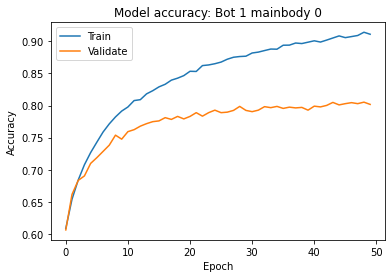

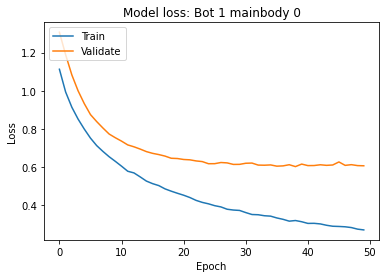

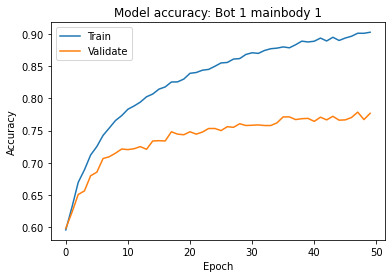

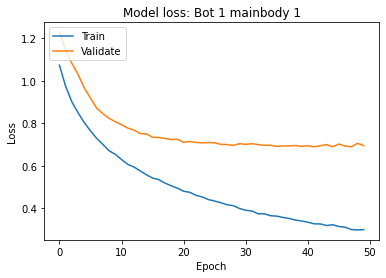

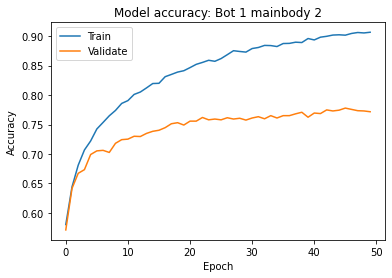

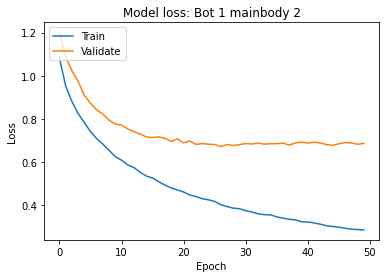

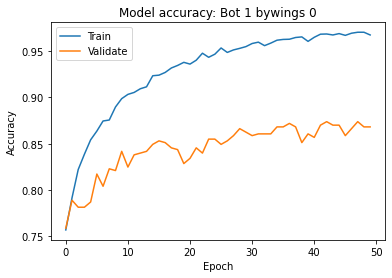

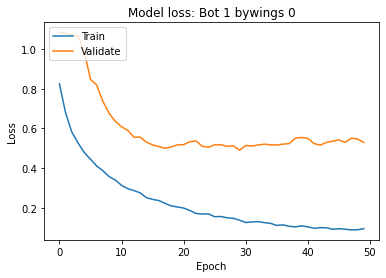

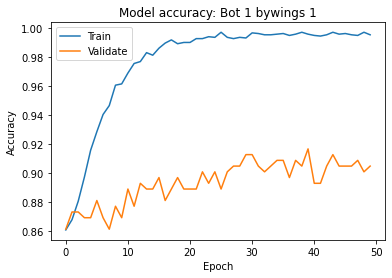

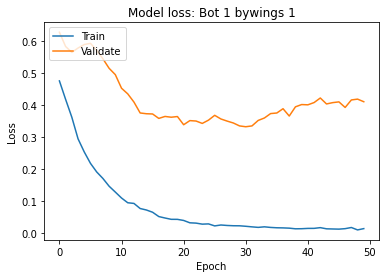

In [63]:
import matplotlib.pyplot as plt

for name, mx in [('mainbody', 3), ('bywings', 2)]:
    for k in range(mx):
        h = record[f'{name}{k}']
        plt.plot(h[1])
        plt.plot(h[3])
        plt.title(f'Model accuracy: Bot {_idx} {name} {k}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validate'], loc='upper left')
        plt.show()

        plt.plot(h[0])
        plt.plot(h[2])
        plt.title(f'Model loss: Bot {_idx} {name} {k}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validate'], loc='upper left')
        plt.show()

In [64]:
import json


with open(f'record{_idx}.json', 'w') as fp:
    json.dump(record, fp)

## main.py

In [1]:
os.environ.get("USER", "") == "root"

False

In [2]:
_BOTZONE_ONLINE = os.environ.get("USER", "") == "root"

my_hand = []
g = Game([[], [], []])
my_pos = -1
others = []
combos = [[(0, 0, 0, 0)], [(0, 0, 0, 0)], [(0, 0, 0, 0)]]
las_combo = (0, 0, 0, 0)

model_path = "./data/fightlandlord_model/" if _BOTZONE_ONLINE else "./model/"

def PLAYING():
    def getFromHand(idx):
        global my_hand
        for c in my_hand:
            if getCardId(c) == idx:
                my_hand.remove(c)
                return c
    
    to_play = []
        
    model_name = "best_model_for_bot" + str(_idx) + "_player" + str(my_pos) + "_mainbody.pt"
    model = torch.load(model_path + model_name, map_location = torch.device('cpu'))
    
    mask = g.getMask1(my_pos, las_combo)
    combo_id = -1
    if np.sum(mask) == 1:
        combo_id = np.argmax(mask)
    else:
        combo_id = model(torch.from_numpy(g.getInput(my_pos, combos)).unsqueeze(0),
                         torch.from_numpy(mask)).unsqueeze(0).detach().numpy().argmax()
    
    combo = combo_list[combo_id]
    for i in range(combo[1], combo[2] + 1):
        for j in range(combo[0]):
            to_play.append(getFromHand(i))
    g.play(my_pos, to_play)
    
    if combo[3] != 0:
        model_name = "best_model_for_bot" + str(_idx) + "_" + str(combo[3] - 1) + "bywings.pt"
        model = torch.load(model_path + model_name, map_location = torch.device('cpu'))

        cnt = (combo[2] - combo[1] + 1) * (1 if combo[0] == 3 else 2)
        already_played = []
        for i in range(cnt):
            wing_id = model(torch.from_numpy(g.getInput(my_pos, combos)).unsqueeze(0),
                            torch.from_numpy(g.getMask2(my_pos, combo, already_played))).unsqueeze(0).detach().numpy().argmax()
            tmp = []
            if combo[3] == 1:
                tmp = [getFromHand(wing_id)]
            else:
                tmp = [getFromHand(wing_id), getFromHand(wing_id)]
            g.play(my_pos, tmp)
            to_play.extend(tmp)
            already_played.append(wing_id)
    
    print(json.dumps({
        "response": to_play
    }))
    if not _BOTZONE_ONLINE:
        assert 0
    exit()
    
if __name__ == "__main__":
    initCombo()
    data = json.loads(input())
    my_hand, others_hand = data["requests"][0]["own"], []
    for i in range(54):
        if i not in my_hand:
            others_hand.append(i)
    if len(data["requests"][0]["history"][0]) != 0:
        my_pos = 2
    elif len(data["requests"][0]["history"][1]) != 0:
        my_pos = 1
    else:
        my_pos = 0
    others = [(my_pos + 1) % 3, (my_pos + 2) % 3]
    tmp = [[], [], []]
    if my_pos == 0:
        tmp[0] = my_hand
        tmp[1], tmp[2] = others_hand[:17], others_hand[17:]
    else:
        tmp[my_pos] = my_hand
        tmp[0] = others_hand[:20]
        tmp[3 - my_pos] = others_hand[20:]
    g = Game(tmp)
    
    for i in range(len(data["requests"])):
        history = data["requests"][i]["history"]
        for j in range(2):
            p = others[j]
            cards = history[j]
            g.play(p, cards)
            combos[p].append(getCombo(cards))

        if i < len(data["requests"]) - 1:
            cards = data["responses"][i]
            g.play(my_pos, cards)
            for c in cards:
                my_hand.remove(c)
            combos[my_pos].append(getCombo(cards))
    
    las_combo = (0, 0, 0, 0)
    for i in range(1, 3):
        if combos[(my_pos + i) % 3][-1] != (0, 0, 0, 0):
            las_combo = combos[(my_pos + i) % 3][-1]

    PLAYING()

NameError: name 'Game' is not defined